### Imports and paths

In [2]:
%matplotlib inline

import random
import math
import time
import os
from os.path import join
import sys
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import bz2

from nltk.tokenize import sent_tokenize

from nltk.tokenize import TweetTokenizer
from nltk.tokenize import RegexpTokenizer
tweet_tokenize = TweetTokenizer().tokenize
regex_tokenize = RegexpTokenizer(r'\w+').tokenize

import matplotlib.colors as mcolors
import pickle

from tqdm.notebook import tqdm_notebook

#import statsmodels as sm
import statsmodels.api as sm
import scipy.stats as st
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn import linear_model
from sklearn import preprocessing

dimensions = ['social_support', 'knowledge', 'conflict', 'power', 'similarity', 
              'fun', 'respect', 'trust', 'identity', 'romance']
dimensions_redux = ['social_support', 'knowledge', 'conflict', 'power', 'similarity', 
              'fun', 'respect', 'trust', 'identity']
dimensions_names = ['support', 'knowledge', 'conflict', 'power', 'similarity', 
              'fun', 'status', 'trust', 'identity', 'romance']
dimensions_names_redux = ['support', 'knowledge', 'conflict', 'power', 'similarity', 
                          'fun', 'status', 'trust', 'identity']
dims2name = {'social_support':'support', 'romance':'romance', 'identity':'identity' , 'similarity':'similarity',
             'conflict':'conflict','fun':'fun','knowledge':'knowledge','respect':'status','trust':'trust','power':'power'}

additional_dims = ['vader_sentiment', 'number_of_words']
additional_dims_names = ['sentiment', 'num_words']
additional_dims_names_binarized = ['sentiment_pos', 'sentiment_neg'] 

def ci(x, confidence=0.95):
    avg = np.mean(x)
    low, high = st.t.interval(confidence, len(x)-1, loc=avg, scale=st.sem(x))
    return (avg, high-avg)
    
#dimension-dependent weights
def standardized_dimension_score(x,mu,std):
    zscore = (x-mu)/std
    if zscore >= 0:
        return 1/(1+zscore)
    else:
        zscore = -zscore
        return 2 - (1/(1+zscore))

## Download the processed dataset from here:

[https://github.com/corradomonti/10-dim-of-op-change/releases/tag/changemyview-sociopol-processed](https://github.com/corradomonti/10-dim-of-op-change/releases/tag/changemyview-sociopol-processed)

### Statistics on dataset

In [5]:
D = pd.read_pickle('changemyview-sociopol-processed.pickle.gz')
D

,post_id,comment_id,vader_sentiment_comment,number_of_words,score_comment,is_op,has_delta,has_answer_by_op,log_number_of_words,support_comment,knowledge_comment,conflict_comment,power_comment,similarity_comment,fun_comment,status_comment,trust_comment,identity_comment,romance_comment,sentiment_pos_comment,sentiment_neg_comment,support_weighted_comment,knowledge_weighted_comment,conflict_weighted_comment,power_weighted_comment,similarity_weighted_comment,fun_weighted_comment,status_weighted_comment,trust_weighted_comment,identity_weighted_comment,romance_weighted_comment,sentiment_pos_weighted_comment,sentiment_neg_weighted_comment,vader_sentiment_post,score_post,number_of_words_post,log_number_of_words_post,support_post,knowledge_post,conflict_post,power_post,similarity_post,fun_post,status_post,trust_post,identity_post,romance_post,sentiment_pos_post,sentiment_neg_post,support_weighted_post,knowledge_weighted_post,conflict_weighted_post,power_weighted_post,similarity_weighted_post,fun_weighted_post,status_weighted_post,trust_weighted_post,identity_weighted_post,romance_weighted_post,sentiment_pos_weighted_post,sentiment_neg_weighted_post,profile_similarity,num_links,length,log_num_links,log_length,links_per_length,support_weighted_comment_z,knowledge_weighted_comment_z,conflict_weighted_comment_z,power_weighted_comment_z,similarity_weighted_comment_z,fun_weighted_comment_z,status_weighted_comment_z,trust_weighted_comment_z,identity_weighted_comment_z,sentiment_pos_weighted_comment_z,sentiment_neg_weighted_comment_z,log_num_links_z,log_length_z,links_per_length_z,shared_sub,post_leftwing,comment_leftwing,post_rightwing,comment_rightwing,both_polarized,diff_side
0,1fdcie,t1_ca9d2r3,-0.9465,319.0,1,False,False,False,5.768321,0,1,1,1,1,0,0,0,1,0,0,1,0.000000,0.642677,0.551067,0.580632,0.608968,0.000000,0.000000,0.000000,0.554905,0.000000,0.000000,0.505956,0.9416,291.0,494,6.204558,1,0,0,1,0,0,1,0,0,0,0,0,0.863283,0.0,0.0,0.963878,0.0,0.0,0.886543,0.0,0.0,0.0,0.0,0.0,NaN,0,1613,0.000000,7.386471,0.000000,-0.380345,1.239607,1.017476,1.086854,1.155622,-0.379538,-0.379429,-0.380370,1.033530,-0.381521,0.900442,-0.288975,1.315259,-0.225985,0,False,False,True,False,False,True
1,1fdcie,t1_ca9kgqd,-0.9689,132.0,1,False,False,False,4.890349,0,0,1,0,0,0,0,0,1,1,0,1,0.000000,0.000000,1.156668,0.000000,0.000000,0.000000,0.000000,0.000000,1.122327,0.736505,0.000000,1.056360,0.9416,291.0,494,6.204558,1,0,0,1,0,0,1,0,0,0,0,0,0.863283,0.0,0.0,0.963878,0.0,0.0,0.886543,0.0,0.0,0.0,0.0,0.0,NaN,0,667,0.000000,6.504288,0.000000,-0.380345,-0.381242,2.554335,-0.381281,-0.380642,-0.379538,-0.379429,-0.380370,2.479444,-0.381521,2.295339,-0.288975,0.662496,-0.225985,0,False,False,True,False,False,True
2,1fdcie,t1_ca9su0f,-0.9686,190.0,1,False,False,False,5.252273,0,0,1,0,0,0,0,0,1,0,0,1,0.000000,0.000000,0.815239,0.000000,0.000000,0.000000,0.000000,0.000000,0.800814,0.000000,0.000000,0.731306,0.9416,291.0,494,6.204558,1,0,0,1,0,0,1,0,0,0,0,0,0.863283,0.0,0.0,0.963878,0.0,0.0,0.886543,0.0,0.0,0.0,0.0,0.0,0.0,0,945,0.000000,6.852243,0.000000,-0.380345,-0.381242,1.687877,-0.381281,-0.380642,-0.379538,-0.379429,-0.380370,1.660158,-0.381521,1.471549,-0.288975,0.919962,-0.225985,0,False,True,True,True,True,False
3,1fdcie,t1_ca9cwcv,0.9637,1529.0,1,False,False,False,7.333023,1,1,1,1,1,1,1,1,1,0,1,0,0.300483,0.272094,0.277962,0.275142,0.277549,0.309275,0.312952,0.290667,0.287356,0.000000,0.266403,0.000000,0.9416,291.0,494,6.204558,1,0,0,1,0,0,1,0,0,0,0,0,0.863283,0.0,0.0,0.963878,0.0,0.0,0.886543,0.0,0.0,0.0,0.0,0.0,0.0,1,7787,0.693147,8.960339,0.000128,0.392457,0.304985,0.324406,0.314420,0.319542,0.416842,0.427744,0.360611,0.351755,0.295996,-0.381809,1.950111,2.479827,-0.136001,0,False,False,True,False,False,True
4,1fdcie,t1_ca9tax8,0.9428,158.0,1,False,False,False,5.068904,0,1,0,1,0,0,0,0,0,0,1,0,0.000000,1.281243,0.000000,1.116993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.965602,0.000000,0.9416,291.0,494,6.204558,1,0,0,1,0,0,1,0,0,0,0,0,0.863283,

In [6]:
df_comments = D[['post_id', 'comment_id', 'vader_sentiment_comment','number_of_words','score_comment','is_op','has_delta','has_answer_by_op','log_number_of_words','support_comment','knowledge_comment','conflict_comment','power_comment','similarity_comment','fun_comment','status_comment','trust_comment','identity_comment','romance_comment','sentiment_pos_comment','sentiment_neg_comment','support_weighted_comment','knowledge_weighted_comment','conflict_weighted_comment','power_weighted_comment','similarity_weighted_comment','fun_weighted_comment','status_weighted_comment','trust_weighted_comment','identity_weighted_comment','romance_weighted_comment','sentiment_pos_weighted_comment','sentiment_neg_weighted_comment']]
df_comments.columns = ['post_id', 'comment_id','vader_sentiment','number_of_words','score_comment','is_op','has_delta','has_answer_by_op','log_number_of_words','support','knowledge','conflict','power','similarity','fun','status','trust','identity','romance','sentiment_pos','sentiment_neg','support_weighted','knowledge_weighted','conflict_weighted','power_weighted','similarity_weighted','fun_weighted','status_weighted','trust_weighted','identity_weighted','romance_weighted','sentiment_pos_weighted','sentiment_neg_weighted']

In [7]:
df_comments.head()

,post_id,comment_id,vader_sentiment,number_of_words,score_comment,is_op,has_delta,has_answer_by_op,log_number_of_words,support,knowledge,conflict,power,similarity,fun,status,trust,identity,romance,sentiment_pos,sentiment_neg,support_weighted,knowledge_weighted,conflict_weighted,power_weighted,similarity_weighted,fun_weighted,status_weighted,trust_weighted,identity_weighted,romance_weighted,sentiment_pos_weighted,sentiment_neg_weighted
0,1fdcie,t1_ca9d2r3,-0.9465,319.0,1,False,False,False,5.768321,0,1,1,1,1,0,0,0,1,0,0,1,0.000000,0.642677,0.551067,0.580632,0.608968,0.000000,0.000000,0.000000,0.554905,0.000000,0.000000,0.505956
1,1fdcie,t1_ca9kgqd,-0.9689,132.0,1,False,False,False,4.890349,0,0,1,0,0,0,0,0,1,1,0,1,0.000000,0.000000,1.156668,0.000000,0.000000,0.000000,0.000000,0.000000,1.122327,0.736505,0.000000,1.056360
2,1fdcie,t1_ca9su0f,-0.9686,190.0,1,False,False,False,5.252273,0,0,1,0,0,0,0,0,1,0,0,1,0.000000,0.000000,0.815239,0.000000,0.000000,0.000000,0.000000,0.000000,0.800814,0.000000,0.000000,0.731306
3,1fdcie,t1_ca9cwcv,0.9637,1529.0,1,False,False,False,7.333023,1,1,1,1,1,1,1,1,1,0,1,0,0.300483,0.272094,0.277962,0.275142,0.277549,0.309275,0.312952,0.290667,0.287356,0.000000,0.266403,0.000000
4,1fdcie,t1_ca9tax8,0.9428,158.0,1,False,False,False,5.068904,0,1,0,1,0,0,0,0,0,0,1,0,0.000000,1.281243,0.000000,1.116993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.965602,0.000000


#### Comments delta vs. non-delta

In [8]:
df_comments['nodimensions'] = df_comments[[f'{d}' for d in dimensions_names_redux]].sum(axis=1)
df_comments['nodimensions'] = df_comments['nodimensions'].apply(lambda x : 0 if x>0 else 1)
log_lengths = df_comments[df_comments['nodimensions'] == 1]['log_number_of_words']
avg = np.mean(log_lengths)
stdev = np.std(log_lengths)
df_comments[f'nodimensions_weighted'] = df_comments['log_number_of_words'].apply(lambda x: standardized_dimension_score(x,avg,stdev)) * df_comments['nodimensions']

<ipython-input-8-3907c1da4d49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comments['nodimensions'] = df_comments[[f'{d}' for d in dimensions_names_redux]].sum(axis=1)
<ipython-input-8-3907c1da4d49>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comments['nodimensions'] = df_comments['nodimensions'].apply(lambda x : 0 if x>0 else 1)
<ipython-input-8-3907c1da4d49>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [9]:
df_no_delta = df_comments[df_comments['has_delta'] == False].dropna()
df_delta = df_comments[df_comments['has_delta'] == True].dropna()
df_delta = df_delta[df_delta['is_op'] == False]
df_no_delta = df_no_delta[df_no_delta['is_op'] == False]

++++++++++++support
avg. delta : 0.19121681994224535 count delta: 38217
avg. nodelta : 0.1381402365587678 count nodelta: 3097686
OR = 1.475062393723651
#dim-delta=7307, #nodim-delta=30910, #dim-nodelta=427915, #nodim-nodelta=2669771
>>> 0.0001368550704803613 3.2351989647363315e-05 2.3369127046259187e-06 3.745639607292161e-07
STDERR = 0.013111770925129822
CI LOG = 0.02569907101325445
support 0.19121681994224535 0.1381402365587678 [0.03839902956051211]
++++++++++++knowledge
avg. delta : 0.28330313138905594 count delta: 38217
avg. nodelta : 0.15104566689479657 count nodelta: 3097686
OR = 2.221733309283479
#dim-delta=10826, #nodim-delta=27391, #dim-nodelta=467892, #nodim-nodelta=2629794
>>> 9.237021984112322e-05 3.650834215618269e-05 2.1372453472168793e-06 3.8025792134288843e-07
STDERR = 0.011462812275609581
CI LOG = 0.02246711206019478
knowledge 0.28330313138905594 0.15104566689479657 [0.03839902956051211, 0.05048088768445291]
++++++++++++conflict
avg. delta : 0.17106435210940782 count de

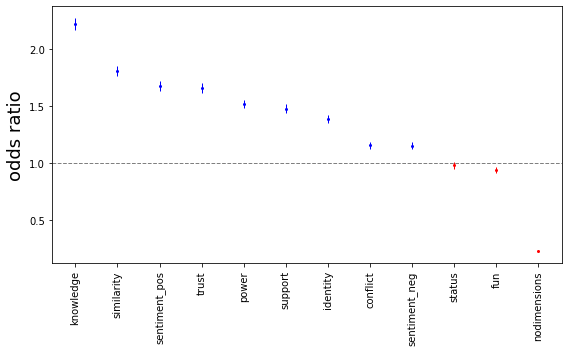

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
y_oddsratio = []
y_ci_OR = []
y_ratio = []
y_delta = []
y_nodelta = []
y_ci_delta= []
y_ci_nodelta = []
colors = []
all_dims = dimensions_names_redux + additional_dims_names_binarized + ['nodimensions']
for i, dim in enumerate(all_dims):
    
    print(f'++++++++++++{dim}')
    scores_delta = df_delta[f'{dim}_weighted'] 
    scores_no_delta = df_no_delta[f'{dim}_weighted'] 

    avg_delta, ci_delta = ci(scores_delta)
    avg_no_delta, ci_no_delta = ci(scores_no_delta)
    
    print(f'avg. delta : {avg_delta} count delta: {len(scores_delta)}')
    print(f'avg. nodelta : {avg_no_delta} count nodelta: {len(scores_no_delta)}')

    OR = (avg_delta / (1 - avg_delta)) / ( avg_no_delta / (1-avg_no_delta) )
    log_OR = np.log(OR)
    y_oddsratio.append(OR)
    y_ratio.append((avg_delta/avg_no_delta)-1)
    y_delta.append(avg_delta/avg_no_delta)
    y_nodelta.append(avg_no_delta)
    y_ci_delta.append(ci_delta/avg_no_delta)
    y_ci_nodelta.append(ci_no_delta/avg_no_delta)
    
    _dim_delta = int(avg_delta*len(scores_delta))
    _no_dim_delta = len(scores_delta) - _dim_delta
    _dim_no_delta = int(avg_no_delta*len(scores_no_delta))
    _no_dim_no_delta = len(scores_no_delta) - _dim_no_delta
    _all_cases = _dim_delta + _no_dim_delta + _dim_no_delta + _no_dim_no_delta
    
    print (f'OR = {OR}')
    print(f'#dim-delta={_dim_delta}, #nodim-delta={_no_dim_delta}, #dim-nodelta={_dim_no_delta}, #nodim-nodelta={_no_dim_no_delta}')
    
    
    print('>>>', 1/_dim_delta , 1/_no_dim_delta , 1/_dim_no_delta , 1/_no_dim_no_delta)
    standard_error_log_OR = np.sqrt(1/_dim_delta + 1/_no_dim_delta + 1/_dim_no_delta + 1/_no_dim_no_delta)
    print(f'STDERR = {standard_error_log_OR}')
    ci_log_OR = 1.96 * standard_error_log_OR
    print(f'CI LOG = {ci_log_OR}')
    ci_log_OR_upper = log_OR + ci_log_OR
    ci_log_OR_lower = log_OR - ci_log_OR
    ci_OR_upper = np.power(np.e,ci_log_OR_upper)
    ci_OR_lower = np.power(np.e,ci_log_OR_lower)
    ci_OR = ci_OR_upper - OR
    y_ci_OR.append(ci_OR)
    
    print(dim, avg_delta, avg_no_delta, y_ci_OR)
    if avg_delta > avg_no_delta:
        clr = 'b'
    else:
        clr = 'r'
    colors.append(clr)

L = list(zip(y_oddsratio,y_ci_OR, y_ratio, y_delta, y_ci_delta, y_nodelta, y_ci_nodelta, colors, all_dims))
L.sort(key=lambda x : x[0], reverse = True)
labels_ordered = []
y_ci_nodelta_ordered = []
for i, l in zip(range(len(L)), L):
    y_odds, y_odds_ci, y_rat, y_d, err_delta, y_nod, err_nodelta, color, label = l
    labels_ordered.append(label)
    y_ci_nodelta_ordered.append(err_nodelta)
    
    ax.plot([i], [y_odds],'o', markersize=2, color=color)
    ax.errorbar([i], [y_odds], yerr=[y_odds_ci], elinewidth=1, fmt=f'{color}-')

ax.set_xticks(range(len(labels_ordered)))
ax.set_xticklabels(labels_ordered)
ax.set_ylabel(f'odds ratio', size=18)
ax.axhline(1, linestyle='--', linewidth=1, color='gray')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.tight_layout()

#### Frequent dimension pairs in post-reply pairs

##### Preparation

In [18]:
#df_paired = D.copy()
df_posts = D[['post_id', 'vader_sentiment_post','score_post','number_of_words_post','log_number_of_words_post','support_post','knowledge_post','conflict_post','power_post','similarity_post','fun_post','status_post','trust_post','identity_post','romance_post','sentiment_pos_post','sentiment_neg_post','support_weighted_post','knowledge_weighted_post','conflict_weighted_post','power_weighted_post','similarity_weighted_post','fun_weighted_post','status_weighted_post','trust_weighted_post','identity_weighted_post','romance_weighted_post','sentiment_pos_weighted_post','sentiment_neg_weighted_post','num_links','length','log_num_links','log_length','links_per_length']]
df_posts.columns = ['post_id', 'vader_sentiment','score_post','number_of_words_post','log_number_of_words_post','support','knowledge','conflict','power','similarity','fun','status','trust','identity','romance','sentiment_pos','sentiment_neg','support_weighted','knowledge_weighted','conflict_weighted','power_weighted','similarity_weighted','fun_weighted','status_weighted','trust_weighted','identity_weighted','romance_weighted','sentiment_pos_weighted','sentiment_neg_weighted','num_links','length','log_num_links','log_length','links_per_length']
df_posts = df_posts.drop_duplicates(subset=['post_id'])
len(df_posts)

45342

In [19]:
df_comments_shuffled = df_comments.copy(deep=True)
print(len(df_comments_shuffled))
df_comments_shuffled['post_id'] = np.random.permutation(df_comments_shuffled['post_id'].values)
print(len(df_comments_shuffled))
#create shuffled versions of comments and join it with pots
df_paired_shuffled = pd.merge(df_comments_shuffled, df_posts, left_on='post_id', right_on='post_id', how='inner', suffixes=('_comment','_post'))
print(len(df_paired_shuffled))

3678849
3678849
3678849


#### Frequent dimension pairs in post-reply pairs

In [20]:
df_paired = D.copy()
df_paired = df_paired[(df_paired['has_delta'] == True) | (df_paired['has_answer_by_op'] == True)] 
df_paired_shuffled = df_paired_shuffled[(df_paired_shuffled['has_delta'] == True) | (df_paired_shuffled['has_answer_by_op'] == True)] 

In [21]:
df_paired_shuffled.head()

,post_id,comment_id,vader_sentiment_comment,number_of_words,score_comment,is_op,has_delta,has_answer_by_op,log_number_of_words,support_comment,knowledge_comment,conflict_comment,power_comment,similarity_comment,fun_comment,status_comment,trust_comment,identity_comment,romance_comment,sentiment_pos_comment,sentiment_neg_comment,support_weighted_comment,knowledge_weighted_comment,conflict_weighted_comment,power_weighted_comment,similarity_weighted_comment,fun_weighted_comment,status_weighted_comment,trust_weighted_comment,identity_weighted_comment,romance_weighted_comment,sentiment_pos_weighted_comment,sentiment_neg_weighted_comment,nodimensions,nodimensions_weighted,vader_sentiment_post,score_post,number_of_words_post,log_number_of_words_post,support_post,knowledge_post,conflict_post,power_post,similarity_post,fun_post,status_post,trust_post,identity_post,romance_post,sentiment_pos_post,sentiment_neg_post,support_weighted_post,knowledge_weighted_post,conflict_weighted_post,power_weighted_post,similarity_weighted_post,fun_weighted_post,status_weighted_post,trust_weighted_post,identity_weighted_post,romance_weighted_post,sentiment_pos_weighted_post,sentiment_neg_weighted_post,num_links,length,log_num_links,log_length,links_per_length
17,47wla6,t3_1h97pa,0.4588,19.0,2,False,False,True,2.995732,0,0,0,0,0,0,1,0,0,1,0,0,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.554175,0.000000,0.0,1.470968,0.000000,0.0,0,0.000000,0.9558,906.0,359,5.886104,0,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.303826,0.0,0.0,0.0,0.0,0.0,1.313465,0.0,0.0,0,1786,0.0,7.488294,0.0
18,47wla6,t1_c8xyy6f,0.0000,8.0,1,False,False,True,2.197225,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1,1.482451,0.9558,906.0,359,5.886104,0,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.303826,0.0,0.0,0.0,0.0,0.0,1.313465,0.0,0.0,0,1786,0.0,7.488294,0.0
20,47wla6,t3_1b84kb,0.9723,189.0,3,False,False,True,5.247024,1,0,0,0,0,1,1,1,0,1,1,0,0.763605,0.0,0.0,0.000000,0.0,0.667745,0.648637,0.833827,0.0,0.627861,0.800348,0.0,0,0.000000,0.9558,906.0,359,5.886104,0,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.303826,0.0,0.0,0.0,0.0,0.0,1.313465,0.0,0.0,0,1786,0.0,7.488294,0.0
35,47wla6,t1_cbsnee8,-0.4019,26.0,1,False,False,True,3.295837,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1,0.906147,0.9558,906.0,359,5.886104,0,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.303826,0.0,0.0,0.0,0.0,0.0,1.313465,0.0,0.0,0,1786,0.0,7.488294,0.0
55,47wla6,t3_1om0ry,0.0762,29.0,1,False,False,True,3.401197,0,0,0,1,0,0,0,0,0,0,0,0,0.000000,0.0,0.0,1.684602,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0,0.000000,0.9558,906.0,359,5.886104,0,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.303826,0.0,0.0,0.0,0.0,0.0,1.313465,0.0,0.0,0,1786,0.0,7.488294,0.0


In [22]:
for t in ['post', 'comment']:
    df_paired[f'nodimensions_{t}'] = sum([df_paired[f'{d}_{t}'] for d in dimensions_names_redux])
    df_paired[f'nodimensions_{t}'] = df_paired[f'nodimensions_{t}'].apply(lambda x : 0 if x>0 else 1)
    df_paired[f'nodimensions_weighted_{t}'] = df_paired[f'nodimensions_{t}']
    
    df_paired[f'anydimensions_{t}'] = sum([df_paired[f'{d}_{t}'] for d in dimensions_names_redux])
    df_paired[f'anydimensions_{t}'] = df_paired[f'anydimensions_{t}'].apply(lambda x : 1 if x>0 else 0)
    df_paired[f'anydimensions_weighted_{t}'] = df_paired[f'anydimensions_{t}']

    if t == 'post':
        log_lengths = df_paired[df_paired[f'nodimensions_{t}'] == 1]['log_number_of_words_post']
        avg = np.mean(log_lengths)
        stdev = np.std(log_lengths)
        df_paired[f'nodimensions_weighted_{t}'] = df_paired['log_number_of_words_post'].apply(lambda x: standardized_dimension_score(x,avg,stdev)) * df_paired[f'nodimensions_{t}']
        df_paired[f'anydimensions_weighted_{t}'] = np.sum([df_paired[f'{d}_weighted_{t}'] for d in dimensions_names_redux])

    df_paired_shuffled[f'nodimensions_{t}'] = sum([df_paired_shuffled[f'{d}_{t}'] for d in dimensions_names_redux])
    df_paired_shuffled[f'nodimensions_{t}'] = df_paired_shuffled[f'nodimensions_{t}'].apply(lambda x : 0 if x>0 else 1)
    df_paired_shuffled[f'nodimensions_weighted_{t}'] = df_paired_shuffled[f'nodimensions_{t}']

##### Delta vs. no-Delta in posts

In [25]:
field_selection = ['post_id', 'comment_id', 'has_delta', 'has_answer_by_op'] 
field_selection += [d+'_post' for d in dimensions_names]
field_selection += [d+'_weighted_post' for d in dimensions_names]
field_selection += ['sentiment_pos_weighted_post', 'sentiment_neg_weighted_post']
field_selection += ['nodimensions_comment', 'nodimensions_post', 'nodimensions_weighted_comment', 'nodimensions_weighted_post']
field_selection += ['anydimensions_comment', 'anydimensions_post', 'anydimensions_weighted_comment', 'anydimensions_weighted_post']
df_posts_delta_nondelta = df_paired[field_selection].drop_duplicates(subset=['post_id', 'comment_id', 'has_delta'])  
#df_posts_delta_nondelta['number_of_words'] = df_posts_delta_nondelta['selftext'].apply(lambda x : len(x.split()))
print(len(df_posts_delta_nondelta))
df_posts_delta_nondelta.head()

339434


,post_id,comment_id,has_delta,has_answer_by_op,support_post,knowledge_post,conflict_post,power_post,similarity_post,fun_post,status_post,trust_post,identity_post,romance_post,support_weighted_post,knowledge_weighted_post,conflict_weighted_post,power_weighted_post,similarity_weighted_post,fun_weighted_post,status_weighted_post,trust_weighted_post,identity_weighted_post,romance_weighted_post,sentiment_pos_weighted_post,sentiment_neg_weighted_post,nodimensions_comment,nodimensions_post,nodimensions_weighted_comment,nodimensions_weighted_post,anydimensions_comment,anydimensions_post,anydimensions_weighted_comment,anydimensions_weighted_post
386,1ffpcv,t3_1ffpcv,False,True,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.754113,0.0,0.000000,0,1,0,1.655992,1,0,1,789917.094858
389,1ffpcv,t1_ca9tr7q,False,True,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.754113,0.0,0.000000,1,1,1,1.655992,0,0,0,789917.094858
391,1ffpcv,t1_ca9uqoc,False,True,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.754113,0.0,0.000000,0,1,0,1.655992,1,0,1,789917.094858
397,1fdnv2,t1_ca9omgo,False,True,0,0,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.660896,0.0,0.0,0.0,0.000000,0.0,1.655709,0,0,0,0.000000,1,1,1,789917.094858
402,1fdnv2,t1_caa5h1l,True,False,0,0,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.660896,0.0,0.0,0.0,0.000000,0.0,1.655709,0,0,0,0.000000,1,1,1,789917.094858


In [26]:
df_posts_delta = df_posts_delta_nondelta[df_posts_delta_nondelta['has_delta'] == True].drop_duplicates().dropna()
print(len(df_posts_delta))
df_posts_delta.head()

31434


,post_id,comment_id,has_delta,has_answer_by_op,support_post,knowledge_post,conflict_post,power_post,similarity_post,fun_post,status_post,trust_post,identity_post,romance_post,support_weighted_post,knowledge_weighted_post,conflict_weighted_post,power_weighted_post,similarity_weighted_post,fun_weighted_post,status_weighted_post,trust_weighted_post,identity_weighted_post,romance_weighted_post,sentiment_pos_weighted_post,sentiment_neg_weighted_post,nodimensions_comment,nodimensions_post,nodimensions_weighted_comment,nodimensions_weighted_post,anydimensions_comment,anydimensions_post,anydimensions_weighted_comment,anydimensions_weighted_post
402,1fdnv2,t1_caa5h1l,True,False,0,0,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.000000,1.660896,0.0,0.000000,0.000000,0.0,0.0,1.655709,0,0,0,0.000000,1,1,1,789917.094858
582,1ffr2q,t1_ca9u2ee,True,False,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0,1,0,1.583011,1,0,1,789917.094858
936,1f81am,t1_ca7qs9o,True,True,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.859442,0.0,0.0,0.782824,0,0,0,0.000000,1,1,1,789917.094858
987,1f81am,t3_1f81am,True,True,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.859442,0.0,0.0,0.782824,0,0,0,0.000000,1,1,1,789917.094858
1192,1fek5s,t1_cab83dx,True,True,0,0,0,0,1,1,0,1,0,0,0.0,0.0,0.0,0.0,1.502854,1.451851,0.0,1.465642,0.000000,0.0,0.0,0.000000,0,0,0,0.000000,1,1,1,789917.094858


In [27]:
df_posts_nodelta = df_posts_delta_nondelta[~df_posts_delta_nondelta['post_id'].isin(df_posts_delta['post_id'])].drop_duplicates().dropna()
print(len(df_posts_nodelta))
df_posts_nodelta.head()

141026


,post_id,comment_id,has_delta,has_answer_by_op,support_post,knowledge_post,conflict_post,power_post,similarity_post,fun_post,status_post,trust_post,identity_post,romance_post,support_weighted_post,knowledge_weighted_post,conflict_weighted_post,power_weighted_post,similarity_weighted_post,fun_weighted_post,status_weighted_post,trust_weighted_post,identity_weighted_post,romance_weighted_post,sentiment_pos_weighted_post,sentiment_neg_weighted_post,nodimensions_comment,nodimensions_post,nodimensions_weighted_comment,nodimensions_weighted_post,anydimensions_comment,anydimensions_post,anydimensions_weighted_comment,anydimensions_weighted_post
386,1ffpcv,t3_1ffpcv,False,True,0,0,0,0,0,0,0,0,0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.754113,0.0,0.0,0,1,0,1.655992,1,0,1,789917.094858
389,1ffpcv,t1_ca9tr7q,False,True,0,0,0,0,0,0,0,0,0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.754113,0.0,0.0,1,1,1,1.655992,0,0,0,789917.094858
391,1ffpcv,t1_ca9uqoc,False,True,0,0,0,0,0,0,0,0,0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.754113,0.0,0.0,0,1,0,1.655992,1,0,1,789917.094858
523,1fc92z,t3_1fc92z,False,True,1,0,0,0,0,0,1,0,0,1,1.524955,0.0,0.0,0.0,0.0,0.0,1.533903,0.0,0.0,1.596717,0.0,0.0,1,0,1,0.000000,0,1,0,789917.094858
556,1fc92z,t1_ca8z8iv,False,True,1,0,0,0,0,0,1,0,0,1,1.524955,0.0,0.0,0.0,0.0,0.0,1.533903,0.0,0.0,1.596717,0.0,0.0,1,0,1,0.000000,0,1,0,789917.094858


support 0.16900795577754482 0.1418788306368719 0.004435757213861552 0.0019444559714726917
      5312 26122 20008 121018 172460 31434 141026 172460
knowledge 0.15031032850263035 0.1614233113605361 0.004272153138190543 0.0020622269924553127
      4724 26710 22764 118262 172460 31434 141026 172460
conflict 0.1535395103463933 0.17315897418135318 0.004272797828604874 0.0021295952249319183
      4826 26608 24419 116607 172460 31434 141026 172460
power 0.15062408472632668 0.16947268263686222 0.0042474933615951616 0.0021059744582290207
      4734 26700 23900 117126 172460 31434 141026 172460
similarity 0.15715028926236496 0.15871271329813005 0.004332765844866637 0.0020498321236228356
      4939 26495 22382 118644 172460 31434 141026 172460
fun 0.15563227266660465 0.13934779304518113 0.004305028609996181 0.0019009715019450701
      4892 26542 19651 121375 172460 31434 141026 172460
status 0.1956484704140205 0.1485805780421113 0.004716694597437038 0.0019863376255826737
      6150 25284 20953 120

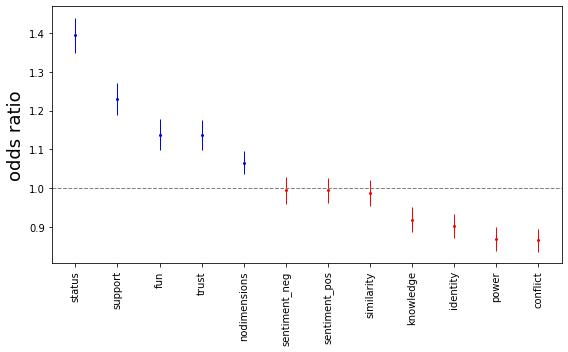

In [29]:
#WEIGHT DISCOUNTED VERSION
fig, ax = plt.subplots(1, 1, figsize=(8,5))

plotfile = open('PLOTFILE_odds_ratios_posts_hasanswer.csv', 'wt', encoding='utf8')
plotfile.write('dimension,odds_ratio,ci_95\n')
y_oddsratio = []
y_ratio = []
y_delta = []
y_nodelta = []
y_ci_delta= []
y_ci_nodelta = []
y_ci_OR = []
colors = []
#all_dims = dimensions_names + additional_dims_names_binarized
for i, dim in enumerate(dimensions_names_redux + ['sentiment_pos', 'sentiment_neg', 'nodimensions']):
    scores_delta = df_posts_delta[f'{dim}_weighted_post'] 
    scores_no_delta = df_posts_nodelta[f'{dim}_weighted_post'] 
    
    avg_delta, ci_delta = ci(scores_delta)
    avg_no_delta, ci_no_delta = ci(scores_no_delta)
    OR = (avg_delta / (1 - avg_delta)) / ( avg_no_delta / (1-avg_no_delta) ) 
    log_OR = np.log(OR)
    y_oddsratio.append( OR )
    y_ratio.append((avg_delta/avg_no_delta)-1)
    y_delta.append(avg_delta/avg_no_delta)
    y_nodelta.append(avg_no_delta)
    y_ci_delta.append(ci_delta/avg_no_delta)
    y_ci_nodelta.append(ci_no_delta/avg_no_delta)
    
    
    _dim_delta = int(avg_delta*len(scores_delta))
    _no_dim_delta = len(scores_delta) - _dim_delta
    _dim_no_delta = int(avg_no_delta*len(scores_no_delta))
    _no_dim_no_delta = len(scores_no_delta) - _dim_no_delta
    _all_cases = _dim_delta + _no_dim_delta + _dim_no_delta + _no_dim_no_delta
    
    standard_error_log_OR = np.sqrt(1/_dim_delta + 1/_no_dim_delta + 1/_dim_no_delta + 1/_no_dim_no_delta)
    ci_log_OR = 1.96 * standard_error_log_OR
    ci_log_OR_upper = log_OR + ci_log_OR
    ci_log_OR_lower = log_OR - ci_log_OR
    ci_OR_upper = np.power(np.e,ci_log_OR_upper)
    ci_OR_lower = np.power(np.e,ci_log_OR_lower)
    ci_OR = ci_OR_upper - OR
    y_ci_OR.append(ci_OR)
    
    plotfile.write(f'{dim},{OR},{ci_OR}\n')

    print(dim, avg_delta, avg_no_delta, ci_delta, ci_no_delta)
    print('     ', _dim_delta,_no_dim_delta,_dim_no_delta , _no_dim_no_delta, 
          _all_cases, len(scores_delta), len(scores_no_delta), len(scores_delta) + len(scores_no_delta))
    if avg_delta > avg_no_delta:
        clr = 'b'
    else:
        clr = 'r'
    colors.append(clr)

L = list(zip(y_oddsratio, y_ci_OR, y_ratio, y_delta, y_ci_delta, y_nodelta, y_ci_nodelta, colors, dimensions_names_redux + [ 'sentiment_pos', 'sentiment_neg', 'nodimensions', 'anydimensions']))
L.sort(key=lambda x : x[0], reverse = True)
labels_ordered = []
y_ci_nodelta_ordered = []
for i, l in zip(range(len(L)), L):
    y_odds, y_odds_ci, y_rat, y_d, err_delta, y_nod, err_nodelta, color, label = l
    labels_ordered.append(label)
    y_ci_nodelta_ordered.append(err_nodelta)
    ax.plot([i], [y_odds],'o', markersize=2, color=color)
    ax.errorbar([i], [y_odds], yerr=[y_odds_ci], elinewidth=1, fmt=f'{color}-')

ax.set_xticks(range(len(labels_ordered)))
ax.set_xticklabels(labels_ordered)
ax.set_ylabel(f'odds ratio', size=18)
ax.axhline(1, linestyle='--', linewidth=1, color='gray')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.tight_layout()
plotfile.close()

##### Comparison with randomized

In [30]:
dimensions_names_extended = dimensions_names_redux + ['nodimensions']#, 'sentiment_pos', 'sentiment_neg']

In [32]:
has_answer_filter=False #HAS ANSWER FILTER

for apply_weighting in ['comment']:#, 'comment', 'both']: #None
    print(f'weighting = {apply_weighting}')
    matrices = {True:None, False:None} #true/false refer to whether they have delta or not
    matrices_shuffled = {True:None, False:None} #true/false refer to whether they have delta or not
    matrices_discounted = {True:None, False:None} #true/false refer to whether they have delta or not

    for is_delta in [True, False]: #loops over delta and no-delta
        print('------Delta = ', is_delta)
        dicts = {'normal':{}, 'shuffled':{}}
        for d, data_type in zip([df_paired, df_paired_shuffled], ['normal', 'shuffled']): #loops over normal and shuffled
            print('---Type = ', data_type)

            #compare delta vs. nodelta
            d = d[d['has_delta'] == is_delta]
            
            if has_answer_filter:
                d = d[(d['has_delta'] == True) | (d['has_answer_by_op'] == True)] 

            print('>', len(d))
            #d = d[(d['number_of_words'] > 0) & (d['number_of_words_post'] > 0)]
            d = d[d['number_of_words'] > 0]
            print('>>', len(d))
            d = d[d['number_of_words_post'] > 0]
            print('>>>', len(d))
            
            d = d [['number_of_words', 'number_of_words_post'] + 
                   [f'{dim}_post' for dim in dimensions_names_extended] +
                   [f'{dim}_comment' for dim in dimensions_names_extended] +
                   [f'{dim}_weighted_post' for dim in dimensions_names_extended] +
                   [f'{dim}_weighted_comment' for dim in dimensions_names_extended]
                  ]
            
            d = d.dropna()

            tot_pairs = len(d)
            print(is_delta, data_type, tot_pairs)
            dim2matches = dicts[data_type]
            for dim1 in dimensions_names_extended: #looks at dim1 in posts
                dim2matches[dim1] = {}
                for dim2 in dimensions_names_extended: #looks at dim2 in comments 
                    d['in_post'] = d[f'{dim1}_post'].apply(bool) # dim1 in post
                    d['in_comment'] = d[f'{dim2}_comment'].apply(bool) #dim2 in comments
                    d['in_both'] = d['in_comment'] & d['in_post'] 
                    d['in_post'] = d['in_post'].apply(int)
                    d['in_comment'] = d['in_comment'].apply(int)
                    d['in_both'] = d['in_both'].apply(int)
                    
                    if apply_weighting is None:
                        p_dimpost_and_dimcomment = sum(d['in_both'])/tot_pairs #P(dim1, dim2)
                        p_dimcomment_given_dimpost = sum(d['in_both'])/sum(d['in_post']) #P(dim2 | dim1)
                    elif apply_weighting == 'comment':
                        d['in_both_weighted'] = d[f'{dim2}_weighted_comment'] * d['in_both']
                        p_dimpost_and_dimcomment = (sum(d['in_both_weighted']), tot_pairs) #P(dim1, dim2)
                        p_dimcomment_given_dimpost = (sum(d['in_both_weighted']) , sum(d['in_post'])) #P(dim2 | dim1)
                    elif apply_weighting == 'both':
                        p_dimpost_and_dimcomment = sum(d['in_both_weighted'])/sum(d['inverse_post_length']) #P(dim1, dim2)
                        p_dimcomment_given_dimpost = sum(d['in_both_weighted'])/sum(d['in_post_weighted']) #P(dim2 | dim1)

                    dim2matches[dim1][dim2] = (p_dimpost_and_dimcomment, p_dimcomment_given_dimpost)#p_dimcomment_given_dimpost #p_dimpost_and_dimcomment # p_dimcomment_given_dimpost
        del(d)


        matrix = [[0 for d in dimensions_names_extended] for d in dimensions_names_extended] #empty matrix
        for i,dim1 in enumerate(dimensions_names_extended):
            for j,dim2 in enumerate(dimensions_names_extended):
                v = dicts['normal'][dim1][dim2] #bare probability
                matrix[i][j] = v
        matrices[is_delta] = matrix

        matrix_shuffled = [[0 for d in dimensions_names_extended] for d in dimensions_names_extended] #empty matrix
        for i,dim1 in enumerate(dimensions_names_extended):
            for j,dim2 in enumerate(dimensions_names_extended):
                v = dicts['shuffled'][dim1][dim2] #shuffled probability
                matrix_shuffled[i][j] = v
        matrices_shuffled[is_delta] = matrix_shuffled

        matrix_discounted = [[0 for d in dimensions_names_extended] for d in dimensions_names_extended] #empty matrix
        for i,dim1 in enumerate(dimensions_names_extended):
            for j,dim2 in enumerate(dimensions_names_extended):
                p_joint_pair, p_cond_pair = dicts['normal'][dim1][dim2]
                p_joint = p_joint_pair[0]/p_joint_pair[1]
                p_cond = p_cond_pair[0]/p_cond_pair[1]
                p_joint_shuffled_pair, p_cond_shuffled_pair = dicts['shuffled'][dim1][dim2]
                p_joint_shuffled = p_joint_shuffled_pair[0]/p_joint_shuffled_pair[1]
                p_cond_shuffled = p_cond_shuffled_pair[0]/p_cond_shuffled_pair[1]
                
                
                stderr_log_joint_pval = np.sqrt(1/p_joint_pair[0] + 1/p_joint_pair[1] + 1/p_joint_shuffled_pair[0] + 1/p_joint_shuffled_pair[1])

                
                or_joint = (p_joint / (1-p_joint)) / (p_joint_shuffled / (1-p_joint_shuffled))
                or_cond = (p_cond / (1-p_cond)) / (p_cond_shuffled / (1-p_cond_shuffled))
                
                print(or_joint, or_cond,stderr_log_joint_pval)                
                
                matrix_discounted[i][j] = (or_joint, or_cond, stderr_log_joint_pval)
        matrices_discounted[is_delta] = matrix_discounted

    if apply_weighting is None:
        weight_suffix = 'unweighted'
    else:
        weight_suffix = f'weighted-{apply_weighting}'
    if has_answer_filter:
        suffix = '_hasanswer'
    else:
        suffix = ''

weighting = comment
------Delta =  True
---Type =  normal
> 38223
>> 38223
>>> 38223
True normal 38223
---Type =  shuffled
> 38223
>> 38223
>>> 38223
True shuffled 38223
1.4962748583935388 1.5171263094393208 0.036452540361664384
1.0177860470052782 0.9363567382450623 0.03280992406321071
0.9326348181186727 0.8539977008364861 0.04221503698245134
1.0299430227679807 0.9555900436548367 0.03749517752988903
1.149776603275727 1.0946587858876966 0.035610770235466875
1.0677184632496965 0.9995294012948929 0.04595101983437531
1.2959500345159203 1.2448346649274733 0.045764214046605516
1.2226171681907136 1.1820484085751861 0.03563135905165156
1.0239294608994773 0.9503164427298266 0.039625754173116735
0.8818047864295474 0.8011542750588583 0.042884938961448
1.0156823145317826 0.9605157284817124 0.04384346939098071
1.1510693649971429 1.1313890004411673 0.03467853596685795
0.9094563790955642 0.8460142461631989 0.04716769270634496
1.1276022295862491 1.091941649094807 0.03969177447695987
1.10216299356875 1

matrix_NEW_weighted-comment_discounted


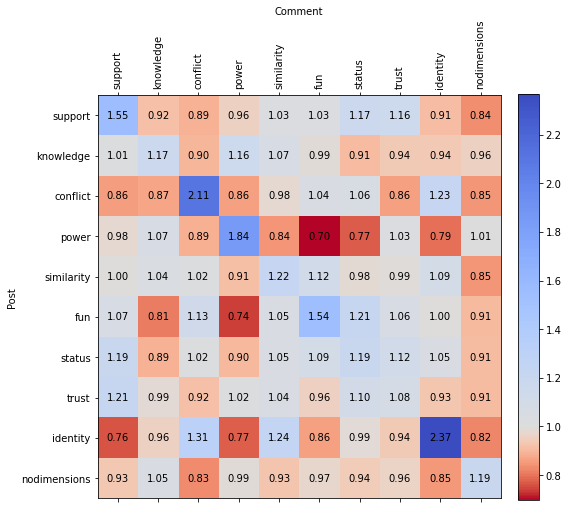

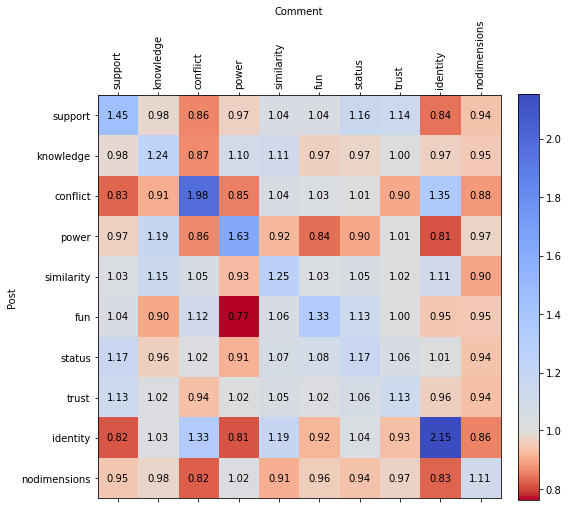

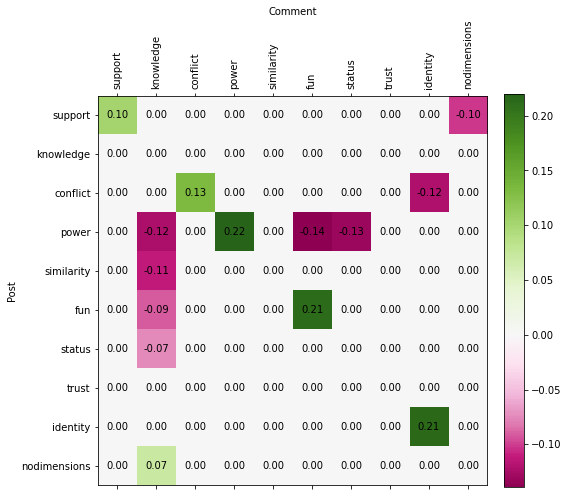

In [33]:
import scipy.stats as st
suffix = ''#, '_hasanswer' #'_condprob_noshuffle' #'_alignment_comparison' '_hasanswer'
p_type = 'cond' #'cond' #'joint'
transformation = '_discounted' #'_shuffled' #'_discounted', #''
for weight in ['weighted-comment']:#['unweighted', 'weighted-comment', 'weighted-both']:
    fname=f'matrix_NEW_{weight}{transformation}{suffix}'
    print(fname)
    matrices = pickle.load(open(fname, 'rb'))
    matrices
    M = {True:None, False:None}
    for is_delta in matrices:
        matrix = matrices[is_delta]
        matrix_joint = [[0 for d in dimensions_names_extended] for d in dimensions_names_extended] 
        matrix_cond = [[0 for d in dimensions_names_extended] for d in dimensions_names_extended] 
        matrix_stderr = [[0 for d in dimensions_names_extended] for d in dimensions_names_extended] 
        for i,dim1 in enumerate(dimensions_names_extended):
            for j,dim2 in enumerate(dimensions_names_extended):
                p_joint = matrix[i][j][0]
                p_cond = matrix[i][j][1]
                stderr = matrix[i][j][2]
                matrix_joint[i][j] = p_joint
                matrix_cond[i][j] = p_cond
                matrix_stderr[i][j] = stderr
        if p_type == 'cond':
            matrix = matrix_cond
        elif p_type == 'joint':
            matrix = matrix_joint

        M[is_delta] = (matrix,matrix_stderr)

        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        cmap = matplotlib.cm.get_cmap('coolwarm_r')#coolwarm_r #Blues
        #norm=mcolors.Normalize())
        cax = ax.matshow(matrix, interpolation='nearest', cmap=cmap, 
                         norm=mcolors.TwoSlopeNorm(vcenter=1.0))
        #cmap = matplotlib.cm.get_cmap('Blues')
        #cax = ax.matshow(matrix, interpolation='nearest', cmap=cmap)
        ax.set_xticks(range(0,len(dimensions_names_extended)))
        ax.set_yticks(range(0,len(dimensions_names_extended)))
        ax.set_xticklabels(dimensions_names_extended)
        ax.set_yticklabels(dimensions_names_extended)
        fig.colorbar(cax, fraction=0.046, pad=0.04)
        ax.set_ylabel('Post')
        ax.set_xlabel('Comment')
        ax.xaxis.set_label_position('top')
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)

        #add labels
        for i,dim1 in enumerate(dimensions_names_extended):
            for j,dim2 in enumerate(dimensions_names_extended):
                c = matrix[i][j]
                ax.text(j, i, f'{c:.2f}', va='center', ha='center')

        plt.tight_layout()
        if is_delta: 
            plt.savefig(f'figs/matrix_{p_type}_{weight}_delta{transformation}.pdf', transparent=False, dpi=400)
        else:
            plt.savefig(f'figs/matrix_{p_type}_{weight}_nodelta{transformation}.pdf', transparent=False, dpi=400)

    diff_matrix = [[0 for d in dimensions_names_extended] for d in  dimensions_names_extended] #empty matrix
    pval_matrix = [[0 for d in dimensions_names_extended] for d in  dimensions_names_extended] #empty matrix
    for i,dim1 in enumerate(dimensions_names_extended):
        for j,dim2 in enumerate(dimensions_names_extended):
            difference = M[True][0][i][j] - M[False][0][i][j]
            errors = np.sqrt(M[True][1][i][j]**2 + M[False][1][i][j]**2)
            Z = difference/errors
            #pval = st.norm.cdf(Z)
            pval = scipy.stats.norm.sf(abs(Z))
            if pval <= 0.01:
                diff_matrix[i][j] = difference
            else:
                diff_matrix[i][j] = 0#difference

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cmap = matplotlib.cm.get_cmap('PiYG')
    cax = ax.matshow(diff_matrix, interpolation='nearest', cmap=cmap, 
                     norm=mcolors.TwoSlopeNorm(vcenter=0.0))
    #cmap = matplotlib.cm.get_cmap('Blues')
    #cax = ax.matshow(matrix, interpolation='nearest', cmap=cmap)
    ax.set_xticks(range(0,len(dimensions_names_extended)))
    ax.set_yticks(range(0,len(dimensions_names_extended)))
    ax.set_xticklabels(dimensions_names_extended)
    ax.set_yticklabels(dimensions_names_extended)
    fig.colorbar(cax,fraction=0.046, pad=0.04)
    ax.set_ylabel('Post')
    ax.set_xlabel('Comment')
    ax.xaxis.set_label_position('top')
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

    #add labels
    for i,dim1 in enumerate(dimensions_names_extended):
        for j,dim2 in enumerate(dimensions_names_extended):
            c = diff_matrix[i][j]
            ax.text(j, i, f'{c:.2f}', va='center', ha='center')

    plt.tight_layout()